# JWDAT Use Case: Spectral Extraction

***

## Imports
We will be using the following libraries to perform optimal spectral extraction.
- `glob glob` for collecting filenames
- `numpy` to handle array functions, as well as other various and sundry activities
- `jwst.datamodels ImageModel, MultiSpecModel` for accessing the datamodels for our example data
- `astropy.io fits` for low-level FITS file I/O
- `astropy.modeling models, fitting` for the many fitting tasks
- `astropy.visualization astropy_mpl_style, simple_norm` for displaying nice images
- `scipy.interpolate interp1d, RegularGridInterpolator` for all our interpolation needs
- `matplotlib.pyplot` for plotting data
- `matplotlib.patches Rectangle` for plotting rectangles on our data
- `ipywidgets` to create interactive widgets for adjusting fit parameters
- `webbpsf NIRSpec` to generate and visualize a PSF from the instrument model (see Appendix B)

In [1]:
%matplotlib inline
from glob import glob
import numpy as np
from jwst.datamodels import ImageModel, MultiSpecModel
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.visualization import astropy_mpl_style, simple_norm
from scipy.interpolate import interp1d, RegularGridInterpolator
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ipywidgets import interact
import ipywidgets as widgets
from webbpsf import NIRSpec, display_psf
plt.style.use(astropy_mpl_style) #use the style we imported for matplotlib displays
plt.ioff() # we unintuitively need to turn off interactive plots

## Introduction
The JWST pipeline produces 1-D and 2-D rectified spectra from combined exposures for each spectroscopic mode. In the future, the 1-D spectral output will involve aperture extraction, including optimal extraction of point sources. However, there are many situations in which the output will not necessarily be "optimal", and fine-tuning the parameters will be needed to improve the results. This notebook is intended to provide a walkthrough of the optimal extraction procedure with example JWST data.

### Defining terms
__Optimal extraction:__ a method of aperture extraction first defined in [Horne (1986)](https://ui.adsabs.harvard.edu/abs/1986PASP...98..609H/).

__S/N:__ Signal-to-noise ratio, a measure of how noisy a spectrum is.

__WCS:__ World Coordinate System, used for converting between different reference frames.

***

## Loading data
We will be using simulated level 3 MOS data provided by James Muzerolle. These files come from a simulated visit with many point sources, and we will begin with the products of the `resample` step, which have the file extension `s2d.fits`. We will also compare the results of our optimal extraction with the products of the `extract1d` step, with the `x1d.fits` extension. See [the science data products specification](https://jwst-pipeline.readthedocs.io/en/stable/jwst/data_products/product_types.html#stage-3-data-products) and links therein for details on structure and format of these files.

Note that the simulation had some problems with spectral resampling and combination, so the data quality is not particularly good. (Hopefully there will be better data in a future version of the notebook!)

The optimal extraction procedure laid out below can be repeated for each `'SCI'` extension in each `s2d` file. For the purposes of this notebook, we will assume that the `resample` step has produced optimal output (despite the caveat above), so those are the only extensions we need to access.

In [2]:
import os
import zipfile
import urllib.request
boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/optimal_extraction/optimal_extraction.zip'
boxfile = './optimal_extraction.zip'
urllib.request.urlretrieve(boxlink, boxfile)
zf = zipfile.ZipFile(boxfile, 'r')
zf.extractall()

example_file = 'F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s35193_'
s2d_file = os.path.join('s2d_files', example_file+'s2d.fits')
x1d_file = os.path.join('x1d_files', example_file+'x1d.fits')

In [3]:
data_model = ImageModel(s2d_file)
resampled_2d_image = data_model.data # if multiple SCI extensions, also specify EXTVER
weights_2d_image = data_model.wht # we will use this to estimate the per-pixel variance later

image_shape = resampled_2d_image.shape
print(image_shape) #note the swap of x and y

(26, 1443)


When we want to view 2d spectra, we'll generally need to stretch the pixels vertically to get a useful image. We can do this by setting the plot aspect to `'auto'`.

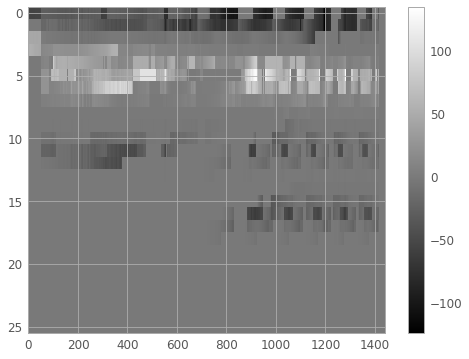

In [4]:
norm = simple_norm(resampled_2d_image, stretch='power')
fig1 = plt.figure() # we save these in dummy variables to avoid spurious Jupyter Notebook output
img1 = plt.imshow(resampled_2d_image, cmap='gray', aspect='auto', 
                  norm=norm, interpolation='none')
clb1 = plt.colorbar()
plt.show()

***

# Optimal Extraction algorithm

Here is an outline of the steps we'll be following:
1. [Define an extraction region on the 2D image](#Define-an-extraction-region)
1. [Identify a high S/N cross-dispersion (binned & coadded) slice to use for the initial kernel fit](#Create-kernel-slice)
3. [Define the extraction kernel](#Define-the-extraction-kernel)
    1. Single or composite PSF
    1. Polynomial fit to background
4. [Fit extraction kernel to initial slice](#Fit-extraction-kernel)
5. ***Skipped:*** [*Fit geometric distortion*](#Fit-geometric-distortion-(skipped))
    1. *Determine cross-dispersion bins for trace fitting*
    1. *First-pass fit of kernel to each bin to find trace center*
    1. *Polynomial fit of trace centers*
6. [Combine composite model (kernel | trace) with 2D image to create output 1D spectrum](#Construct-final-1D-spectrum)
7. Compare output spectrum with catalog photometry for flux calibration (not sure how to do this yet)

Appendices:
- [Appendix A: Batch Processing](#Appendix-A:-Batch-Processing)
- [Appendix B: WebbPSF](#Appendix-B:-WebbPSF)

# Define an extraction region

We begin by identifying the region in the 2D resampled image which contains the spectral trace we want to extract. For a simple case with only a single source, we can theoretically use the entire image. However, we may still want to exclude large systematic fluctuations in the background which might complicate the fit, or part of the trace with essentially no signal which will make fitting the trace centers difficult.

We can attempt to do this interactively, using sliders to define the bounding box.

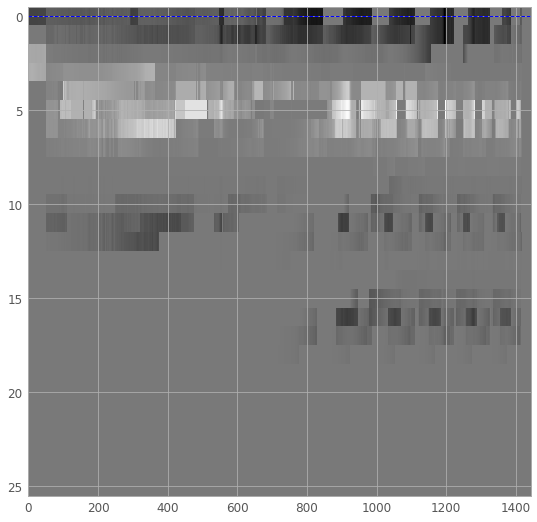

interactive(children=(IntSlider(value=0, description='x1', max=1441), IntSlider(value=0, description='y1', max…

In [5]:
fig2 = plt.figure(figsize=(9,9)) # we want the largest figure that will fit in the notebook
img2 = plt.imshow(resampled_2d_image, cmap='gray', aspect='auto', 
                  norm=norm, interpolation='none') # reuse norm from earlier

# create region box and slider
region_x = region_y = 0
region_h, region_w = image_shape
region_rectangle = Rectangle((region_x, region_y), region_w, region_h, 
                             facecolor='none', edgecolor='b', linestyle='--')
current_axis = plt.gca()
current_axis.add_patch(region_rectangle)
plt.show()

# interactive widget controls
def region(x1=0, y1=0, x2=region_w-1, y2=region_h-1):
    region_rectangle.set_bounds(x1, y1, x2-x1, y2-y1)
    plt.draw()
    
interact1 = interact(region, x1=(0, region_w-2, 1), y1=(0, region_h-2, 1), 
                    x2=(1, region_w-1, 1), y2=(1, region_h-1, 1))

We get the region coordinates from the bounding rectangle -- in this case, setting the coordinates to `x1=45, y1=1, x2=1421, y2=10` seems fine -- or, we can set them directly. Finally, we create a new array containing only our extraction region (so that we don't need to continually index our original array).

0 0 1442 25


<Figure size 576x432 with 0 Axes>

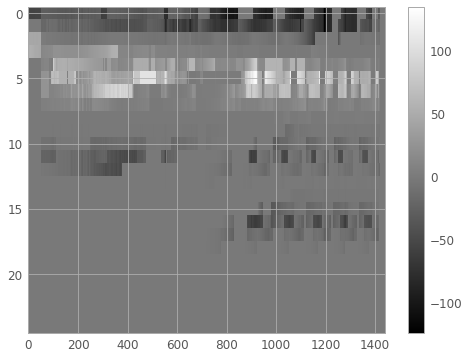

In [6]:
#comment these lines out if interativity is not desired
x, y = region_rectangle.xy
w = region_rectangle.get_width() 
h = region_rectangle.get_height()

#uncomment and set these to your desired extraction region if interativity is not desired
# x = y = 0
# h, w = image_shape

print(x, y, x+w, y+h)

er_y, er_x = np.mgrid[y:y+h, x:x+w]
extraction_region = resampled_2d_image[er_y, er_x]
weights_region = weights_2d_image[er_y, er_x]
er_ny, er_nx = extraction_region.shape

er_norm = simple_norm(extraction_region, stretch='power')
fig3 = plt.figure()
img3 = plt.imshow(extraction_region, cmap='gray', aspect='auto', 
                  norm=er_norm, interpolation='none')
clb3 = plt.colorbar()
plt.show()

# Create kernel slice

We now define a cross-dispersion slice of our extraction region with which to fit our initial extraction kernel. As an initial guess, we'll coadd the 30 columns centered on the column with the highest total signal.

In [7]:
slice_width = 30
initial_column = np.argmax(extraction_region.sum(axis=0))
print("Column with highest signal: {}".format(initial_column))

def kernel_slice_coadd(width, column_idx):
    """
    Coadd a number of columns (= width) of the extraction region,
    centered on column_idx.
    """
    
    half_width = width // 2
    to_coadd = np.arange(max(0, column_idx - half_width), 
                         min(er_nx-1, column_idx + half_width))
    return extraction_region[:, to_coadd].sum(axis=1) / width

slice_0 = kernel_slice_coadd(slice_width, initial_column)

Column with highest signal: 882


Next, we'll plot the resulting slice, and (interactively) adjust the width and center of the coadd region.

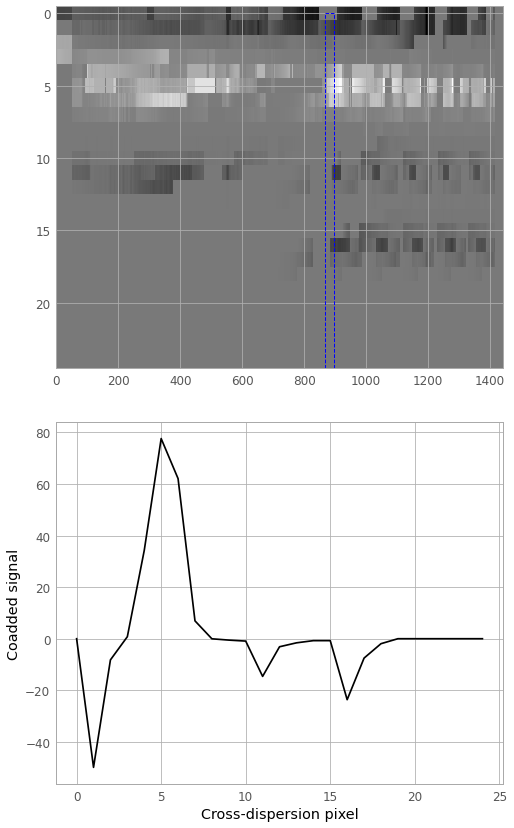

interactive(children=(IntSlider(value=882, description='column_idx', max=1441), IntSlider(value=30, descriptio…

In [8]:
fig4, (iax4, pax4) = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))
plt.subplots_adjust(hspace=0.15, top=0.95, bottom=0.05)
img4 = iax4.imshow(extraction_region, cmap='gray', aspect='auto', 
                  norm=er_norm, interpolation='none')

#create slice box
def make_slice(width, column_idx):
    sy, sh, sw = 0, er_ny, width
    sx = column_idx - width // 2
    return sx, sy, sw, sh

*sxy, sw, sh = make_slice(slice_width, initial_column)
slice_rectangle = Rectangle(sxy, sw, sh, facecolor='none', 
                            edgecolor='b', linestyle='--')
iax4.add_patch(slice_rectangle)

#plot the coadded slice
xd_pixels = np.arange(er_ny)
lin4, = pax4.plot(xd_pixels, slice_0, 'k-')
pax4.set_xlabel('Cross-dispersion pixel')
pax4.axes.set_ylabel('Coadded signal')

plt.show()

column_slider = widgets.IntSlider(initial_column, 0, er_nx-1, 1)
width_slider = widgets.IntSlider(slice_width, 1, er_nx-1, 1)

#interactive controls
def slice_update(column_idx, width):
    #update rectangle
    new_slice_box = make_slice(width, column_idx)
    slice_rectangle.set_bounds(*new_slice_box)
    #update line plot
    lin4.set_ydata(kernel_slice_coadd(width, column_idx))
    plt.draw()

interact2 = interact(slice_update, column_idx=column_slider, width=width_slider)

The defaults seem to work reasonably well for this file, so we can now generate the final slice for kernel fitting.

In [10]:
kernel_slice = kernel_slice_coadd(width_slider.value, column_slider.value)

# Define the extraction kernel

Now we will define an extraction kernel which will be used to fit our trace at each pixel in the dispersion direction. This kernel will be made of 2 parts:
- a PSF template (or a composite of multiple PSFs, for deblending purposes)
- a polynomial for background fitting

## Select a PSF template

There are many options for PSF template that we could consider for our kernel, but a full comparison is outside the scope of this notebook. We will be demonstrating only Gaussian and Moffat profiles. 

Note that the `WebbPSF` package can be used to directly construct a composite PSF from the instrument model; however, this process is far more arduous than fitting a 1D profile using the `astropy.modeling` tools, and has thus been banished to Appendix B.

We start by plotting the two profiles against the kernel slice, with a naive normalization so that we can ignore scaling for the time being, centered on the pixel with the kernel's maximum value. (We will perform a true fit later, don't worry!)

<Figure size 576x432 with 0 Axes>

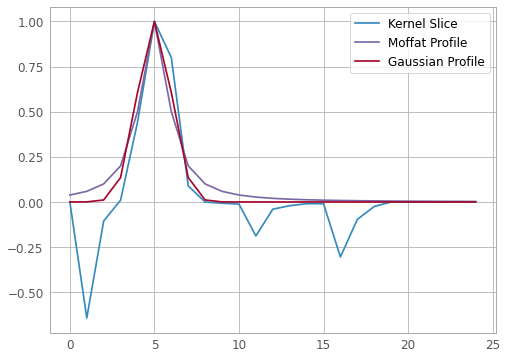

In [11]:
max_pixel = np.argmax(kernel_slice)
fwhm = 1.

moffat_profile = models.Moffat1D(amplitude=1, gamma=fwhm, x_0=max_pixel, alpha=1)
gauss_profile = models.Gaussian1D(amplitude=1, mean=max_pixel, stddev=fwhm)

fig5 = plt.figure()
kern5 = plt.plot(xd_pixels, kernel_slice / kernel_slice[max_pixel], label='Kernel Slice')
moff5 = plt.plot(xd_pixels, moffat_profile(xd_pixels), label='Moffat Profile')
gaus5 = plt.plot(xd_pixels, gauss_profile(xd_pixels), label='Gaussian Profile')
plt.legend()
plt.show()

The Gaussian profile looks like a fine approximation, so that's the profile we'll use for this spectrum. In the cell below, we could add more PSF templates using [model operations](https://docs.astropy.org/en/stable/modeling/compound-models.html); this is left as an exercise for the reader.

We need to de-normalize our amplitude, so we'll set it to the maximum pixel value of the slice.

In [12]:
psf_template = gauss_profile
psf_template.amplitude = kernel_slice[max_pixel]
print(psf_template)
# If deblending multiple sources, add more PSF templates here:





Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude     mean stddev
    ----------------- ---- ------
    77.56583404541016  5.0    1.0


## Polynomial background

We will fit the background with a polynomial. Some experimentation is recommended to find the polynomial degree which best fits the data; for this example, we'll use a 3rd-degree polynomial.

In [13]:
background_poly = models.Polynomial1D(3)
print(background_poly)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 3
Parameters:
     c0  c1  c2  c3
    --- --- --- ---
    0.0 0.0 0.0 0.0


The final step is to combine the PSF(s) and the background to create our compound model.

In [14]:
extraction_kernel = psf_template + background_poly
print(extraction_kernel)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=77.56583405, mean=5., stddev=1.)>

    [1]: <Polynomial1D(3, c0=0., c1=0., c2=0., c3=0.)>
Parameters:
       amplitude_0    mean_0 stddev_0 c0_1 c1_1 c2_1 c3_1
    ----------------- ------ -------- ---- ---- ---- ----
    77.56583404541016    5.0      1.0  0.0  0.0  0.0  0.0


# Fit extraction kernel

Now that we have an extraction kernel, we want to fit it to our kernel slice, so as to have the best tool for fitting trace centers in the next step. We also plot the fit components, as well as the fit vs the kernel slice, as visual checks; if they are unacceptable, we can go back to the previous section, tweak parameters, and try again.

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=90.25944462, mean=5.19781132, stddev=1.04431994)>

    [1]: <Polynomial1D(3, c0=-20.39002613, c1=3.0185882, c2=-0.2057965, c3=0.00493817)>
Parameters:
       amplitude_0          mean_0      ...         c2_1                c3_1       
    ----------------- ----------------- ... -------------------- ------------------
    90.25944462010273 5.197811317567907 ... -0.20579649999004698 0.0049381722789612


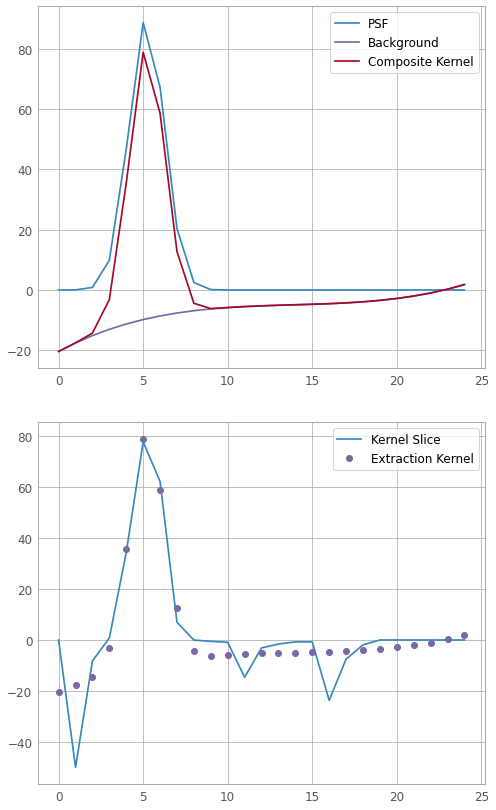

In [15]:
fitter = fitting.LevMarLSQFitter()
fit_extraction_kernel = fitter(extraction_kernel, xd_pixels, kernel_slice)
print(fit_extraction_kernel)

fit_line = fit_extraction_kernel(xd_pixels)

fig6, (fax6, fln6) = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))
plt.subplots_adjust(hspace=0.15, top=0.95, bottom=0.05)
psf6 = fax6.plot(xd_pixels, fit_extraction_kernel[0](xd_pixels), label="PSF")
poly6 = fax6.plot(xd_pixels, fit_extraction_kernel[1](xd_pixels), label="Background")
sum6 = fax6.plot(xd_pixels, fit_line, label="Composite Kernel")
fax6.legend()
lin6 = fln6.plot(xd_pixels, kernel_slice, label='Kernel Slice')
fit6 = fln6.plot(xd_pixels, fit_line, 'o', label='Extraction Kernel')
fln6.legend()
plt.show()

# Fit geometric distortion *(skipped)*

The pipeline `resample` step drizzles all input 2d spectra onto a rectified grid, so this particular step of our optimal extraction process is not typically necessary. A brief discussion of the procedure is included here, as a guideline for unusual situations which require it.

### Define bins for trace fitting

Depending on how noisy the 2D resampled spectrum is, it may be beneficial to define bins in the dispersion direction. These can be evenly- or unevenly-spaced, and once they're defined, coadd the columns in each bin (possibly using the `WHT` extension in the `s2d` file) and create an array of bin center locations.

If the 2D spectrum has high S/N, this may not be necessary, and each cross-dispersed column can be fit individually in the next step.

### Fit each bin with a modified extraction kernel

We want to fit each of the defined bins with our extraction kernel, but we don't want any other artifacts or noise to confuse the trace. So, we copy the extraction kernel, then set each parameter other than the profile center (`mean_0` in the example above) to `fixed = True`. Starting at one end of the trace, iterate over each bin to fit the slice with the extraction kernel, and store the resulting trace centers in an array.

### Fit the trace centers with a 1D polynomial

This step is straightforward: create a `Polynomial1D` model, then fit it to the trace centers from the previous step.

# Construct final 1D spectrum

We calculate the final 1D spectrum as a weighted sum in the cross-dispersion direction the 2D spectrum, using our composite model (the extraction kernel centered on the trace) for the weights. We also need to incorporate the variance for each pixel, which we'll estimate from the `WHT` extension output by the resample step.

### Set the trace centers

(If the geometric distortion was fit in the previous step, we already have a model for `trace_centers`, so skip this.)

In [16]:
trace_center_model = models.Polynomial1D(0) #we use a constant because the spectrum has already been rectified
trace_center_model.c0 = fit_extraction_kernel.mean_0.value # use the parameter for center of the PSF profile
print(trace_center_model)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 0
Parameters:
            c0       
    -----------------
    5.197811317567907


### Create a variance image

Horne's algorithm requires the variance for each pixel. Errors are not currently propagated through the resample step; however, as per the [DrizzlePac Handbook](https://www.stsci.edu/files/live/sites/www/files/home/scientific-community/software/drizzlepac/_documents/drizzlepac-handbook.pdf), we can estimate the variance from the drizzle weights image: $ Var \approx 1 / (W \times s^4) $, where $s$ is the pixel scale. Currently, the NIRSpec drizzle parameters are set to `PIXFRAC = 1.0`.

In [17]:
scale = 1.0 # adjust this if and when the NIRSpec PIXFRAC changes

# We want any pixel with 0 weight to be excluded from the calculation
# in the next step, so we'll use masked array operations.
bad_pixels = weights_region == 0
masked_wht = np.ma.array(weights_region, mask=bad_pixels)
variance_image = np.ma.divide(1., weights_region * scale**4)

### Generate the 1D spectrum

Now, we finally calculate our 1D spectrum, summing over cross-dispersed columns:
$$S_x = \frac{1}{G_x}\sum_{y} \frac{I_{xy}\cdot K_y(x)}{V_{xy}}$$
where $I$ is the pixel value in the 2D resampled image, $K$ is our extraction kernel set to the column's trace center, $V$ is the pixel value in the variance image, and $G$ is the kernel normalization given by:
$$G_x = \sum_y \frac{K_y^2(x)}{V_{xy}}$$

In [18]:
spectrum = np.zeros(er_nx, dtype=float) #initialize our spectrum with zeros
column_pixels = np.arange(er_nx)
trace_centers = trace_center_model(column_pixels) # calculate our trace centers array

# Loop over columns
for x in column_pixels:
    # create the kernel for this column, using the fit trace centers
    kernel_column = fit_extraction_kernel.copy()
    kernel_column.mean_0 = trace_centers[x]
    kernel_values = kernel_column(xd_pixels)
    
    # isolate the relevant column in the spectrum and variance images
    variance_column = variance_image[:, x] # remember that numpy arrays are row, column
    image_pixels = extraction_region[:, x]
    
    # calculate the kernal normalization
    g_x = np.ma.sum(kernel_values**2 / variance_column)
    if np.ma.is_masked(g_x): #this column isn't valid, so we'll skip it
        continue
    
    # and now sum the weighted column
    weighted_column = np.ma.divide(image_pixels * kernel_values, variance_column)
    spectrum[x] = np.ma.sum(weighted_column) / g_x

For displaying our spectrum, we can convert pixel values to wavelengths using the WCS object stored in the metadata.

In [19]:
wcs = data_model.meta.wcs
print(wcs.__repr__())
alpha_C, delta_C, y = wcs(er_x, er_y)
wavelength = y[0]

<WCS(output_frame=world, input_frame=detector, forward_transform=Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('alpha_C', 'delta_C', 'y')
Model set size: 1
Expression: [0] | ([1] & [2] | [3] | [4]) & [5]
Components: 
    [0]: <Mapping((1, 1, 0))>

    [1]: <Linear1D(slope=-0.00002021, intercept=0.00014148)>

    [2]: <Linear1D(slope=-0.00002044, intercept=0.00014305)>

    [3]: <Pix2Sky_Gnomonic()>

    [4]: <RotateNative2Celestial(lon=53.20067664, lat=-27.79802674, lon_pole=180.)>

    [5]: <Tabular1D(points=(array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.440e+03, 1.441e+03,
           1.442e+03]),), lookup_table=[1.64795534 1.64795534 1.64795534 ... 3.17666047 3.1777181  3.17877572])>
Parameters:
           slope_1              intercept_1       ...        lat_4        lon_pole_4
    ---------------------- ---------------------- ... ------------------- ----------
    -2.021169386517732e-05 0.00014148192799462962 ... -27.798026741595898      180.0)>


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


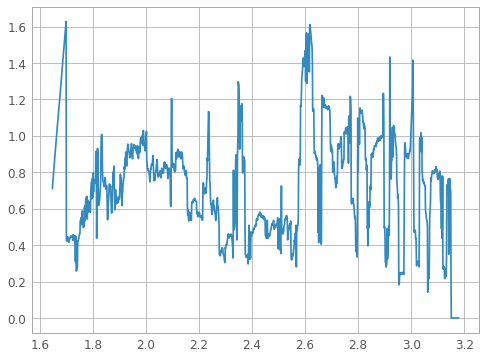

In [20]:
fig7 = plt.figure()
spec7 = plt.plot(wavelength, spectrum)
plt.show()

In [21]:
# Write the extracted spectrum out to a file
# This is left as an exercise for the reader




We also want to compare our optimally-extracted spectrum with the `x1d` pipeline product.

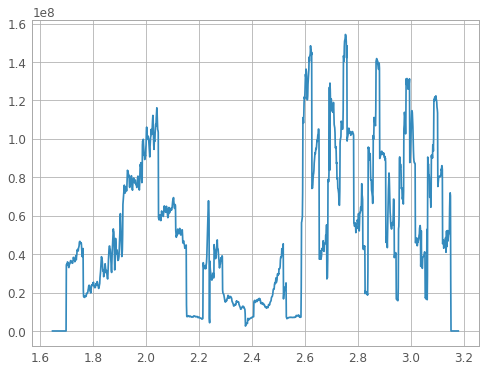

In [22]:
x1d_model = MultiSpecModel(x1d_file)
# For a file with multiple spectra, the index to .spec is EXTVAR-1
x1d_wave = x1d_model.spec[0].spec_table.WAVELENGTH
x1d_flux = -x1d_model.spec[0].spec_table.FLUX # currently, the output is essentially a negative trace
fig8 = plt.figure()
plt.plot(x1d_wave, x1d_flux)
plt.show()

---

# Appendix A: Batch Processing

When optimal extraction is desired for a large number of spectra, going step-by-step through the process laid out above for each spectrum may not be practical. In such cases, we can initially use those interactive methods on one or two spectra to make decisions about some of our extraction parameters (e.g., what PSF template profile to use, or what degree polynonmial to fit the background with), then use those parameters to process all of the spectra non-interactively. Afterwards, we can examine the output from each extracted spectrum and revisit any which need more individualized handling.

We can extract a large number of spectra non-interactively by defining functions for each of the steps above, and a single master function to iterate over all the spectra in a single directory.

### Define an extraction region

There's no way to perform this step non-interactively, so we'll skip it here. However, there are two good ways (and one bad way) to deal with this for a real dataset:
1. Define an extraction region for each 2D spectrum before batch processing. You can save the region bounding boxes to a python dictionary (or write them to a file, then read it in during iteration).
1. Visually examine the 2D spectra, and only batch process those spectra for which a specific extraction region (i.e., smaller than the full 2D spectrum) doesn't need to be defined. The remainder of the spectra can be extracted individually.
1. Skip this step, and assume that any spectra for which a specific extraction region would need to be defined will need individualized reprocessing anyway. This step is not recommended, but it is the one we will be using here.

### Create Kernel Slice

In [23]:
def batch_kernel_slice(extraction_region, slice_width=30, column_idx=None):
    """
    Create a slice in the cross-dispersion direction out of the 
    2D array `extraction_region`, centered on `column_idx` and 
    `slice_width` pixels wide. If `column_idx` is not given, use
    the column with the largest total signal.
    """
    
    if column_idx is None:
        column_idx = np.argmax(extraction_region.sum(axis=0))
        
    ny, nx = extraction_region.shape
    half_width = slice_width // 2
    
    #make sure we don't go past the edges of the extraction region
    to_coadd = np.arange(max(0, column_idx - half_width), 
                         min(nx-1, column_idx + half_width))
    
    return extraction_region[:, to_coadd].sum(axis=1) / slice_width
    

### Create and fit the extraction kernel

In [24]:
def batch_fit_extraction_kernel(xd_slice, psf_profile=models.Gaussian1D, 
                          height_param_name='amplitude', height_param_value=None,
                          width_param_name='stddev', width_param_value=1.,
                          center_param_name='mean', center_param_value=None,
                          other_psf_args=[], other_psf_kw={},
                          bg_model=models.Polynomial1D,
                          bg_args=[3], bg_kw={}):
    """
    Initialize a composite extraction kernel, then fit it to 
    the 1D array `xd_slice`, which has been nominally
    generated via the `kernel_slice` function defined above. 
    
    To allow for PSF template models with different parameter 
    names, we use the `height_param_*`, `width_param_*`, and
    `center_param_*` keyword arguments. We collect any other
    positional or keyword arguments for the PSF model in 
    `other_psf_*`. If the height or center values are `None`, 
    they will be calculated from the data.
    
    Similarly, any desired positional or keyword arguments to
    the background fit model (default `Polynomial1D`) are
    accepted via `bg_args` and `bg_kw`.
    
    Note that this function can not handle cases which involve
    multiple PSFs for deblending. It is recommended to process
    such spectra individually, using the interactive procedure
    above.
    """
    xd_pixels = np.arange(xd_slice.size)
    
    if center_param_value is None:
        center_param_value = np.argmax(xd_slice)
    
    if height_param_value is None:
        # In case of non-integer values passed via center_param_value,
        # we need to interpolate.
        slice_interp = interp1d(xd_pixels, xd_slice)
        height_param_value = slice_interp(center_param_value)
    
    # Create the PSF and the 
    psf_kw = dict([(height_param_name, height_param_value), 
                   (width_param_name, width_param_value),
                   (center_param_name, center_param_value)])
    psf_kw.update(other_psf_kw)
    psf = psf_profile(*other_psf_args, **psf_kw)
    
    bg = bg_model(*bg_args, **bg_kw)
    
    composite_kernel = psf + bg
    fitter = fitting.LevMarLSQFitter()
    return fitter(composite_kernel, xd_pixels, xd_slice)

### Fit the trace centers

If this is required, replace this with a real function that does the fitting.

In [25]:
def batch_fit_trace_centers(extraction_region, kernel,
                      trace_model=models.Polynomial1D,
                      trace_args=[0], trace_kw={}):
    """
    Fit the geometric distortion of the trace with
    a model. Currently this is a placeholder function,
    since geometric distortion is typically removed
    during the `resample` step. However, if this
    functionality is necesary, use this function
    signature to remain compatible with the rest of
    this Appendix.
    """
    
    trace_centers = trace_model(*trace_args, **trace_kw)
    trace_centers.c0 = kernel.mean_0
    return trace_centers

### Generate the 1D spectrum



In [26]:
def batch_extract_spectrum(extraction_region, trace, kernel, 
                     weights_image, 
                     trace_center_param='mean',
                     scale=1.0):
    """
    Optimally extract the 1D spectrum from the extraction 
    region.
    
    A variance image is created from `weights_image` (which 
    should have the same dimensions as `extraction_region`).
    Then, for each column of the spectrum, we sum the aperture
    as per the equations defined above, masking pixels with
    zero weights. 
    
    Note that unlike the interactive, step-by-step method, 
    here we will vectorize for speed. This requires using
    a model set for the kernel, but this is allowed since
    we are not fitting anything.
    
    `trace_center_param` is the name of the parameter which 
    will defines the trace centers, *without the model number
    subscript* (since we will be dealing with the components
    individually).
    
    `scale` is the size ratio of input to output pixels when
    drizzling, equivalent to PIXFRAC in the drizzle parameters
    from the `resample` step.
    """
    
    bad_pixels = weights_image == 0.
    masked_wht = np.ma.array(weights_image, mask=bad_pixels)
    variance_image = np.ma.divide(1., masked_wht * scale**4)
    
    ny, nx = extraction_region.shape
    trace_pixels = np.arange(nx)
    xd_pixels = np.arange(ny)
    trace_centers = trace(trace_pixels) # calculate our trace centers array
    
    # Create kernel image for vectorizing, which requires some gymnastics...
    # ******************************************************************
    # * IMPORTANT:                                                     *
    # * ----------                                                     *
    # * Note that because of the way model sets are implemented, it is *
    # * not feasible to alter an existing model instance to use them.  *
    # * Instead we'll create a new kernel instance, using the fitted   *
    # * parameters from the original kernel.                           *
    # *                                                                *
    # * Caveat: this assumes that the PSF is the first element, and    *
    # * the background is the second. If you change that when creating *
    # * your composite kernel, make sure you update this section       *
    # * similarly, or it will not work!                                *
    # ******************************************************************
    psf0, bg0 = kernel
    psf_params = {}
    for pname, pvalue in zip(psf0.param_names, psf0.parameters):
        if pname == trace_center_param:
            psf_params[pname] = trace_centers
        else:
            psf_params[pname] = np.full(nx, pvalue)
    psf_set = psf0.__class__(n_models=nx, **psf_params)
    #if not using Polynomial1D for background model, edit this:
    bg_set = bg0.__class__(len(bg0.param_names)-1, n_models=nx)
    for pname, pvalue in zip(bg0.param_names, bg0.parameters):
        setattr(bg_set, pname, np.full(nx, pvalue))
    kernel_set = psf_set + bg_set
    # We pass model_set_axis=False so that every model in the set 
    # uses the same input, and we transpose the result to fix the
    # orientation.
    kernel_image = kernel_set(xd_pixels, model_set_axis=False).T
    
    # Now we perform our weighted sum, using numpy.ma routines
    # to preserve our masks
    g = np.ma.sum(kernel_image**2 / variance_image, axis=0)
    weighted_spectrum = np.ma.divide(kernel_image * extraction_region, variance_image)
    spectrum1d = np.ma.sum(weighted_spectrum, axis=0) / g
    
    # Any masked values we set to 0.
    return spectrum1d.filled(0.)

### Convenience functions

In [27]:
def batch_wavelength_from_wcs(datamodel, pix_x, pix_y):
    """
    Convenience function to grab the WCS object from the
    datamodel's metadata, generate world coordinates from
    the given pixel coordinates, and return the 1D 
    wavelength.
    """
    
    wcs = datamodel.meta.wcs
    aC, dC, y = wcs(pix_x, pix_y)
    return y[0]

def batch_save_extracted_spectrum(filename, wavelength, spectrum):
    """
    Quick & dirty fits dump of an extracted spectrum.
    Replace with your preferred output format & function.
    """
    
    wcol = fits.Column(name='wavelength', format='E', 
                       array=wavelength)
    scol = fits.Column(name='spectrum', format='E',
                       array=spectrum)
    cols = fits.ColDefs([wcol, scol])
    hdu = fits.BinTableHDU.from_columns(cols)
    hdu.writeto(filename, overwrite=True)

def batch_plot_output(resampled_image, extraction_bbox, 
                kernel_slice, kernel_model,
                wavelength, spectrum, filename):
    """
    Convenience function for summary output figures,
    allowing visual inspection of the results from 
    each file being processed.
    """
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, 
                                        figsize=(8,12))
    fig.suptitle(filename)
    
    # Subplot 1: Extraction region
    power_norm = simple_norm(resampled_image, 'power')
    er_img = ax1.imshow(resampled_image, interpolation='none',
               aspect='auto', norm=power_norm, cmap='gray')
    rx, ry, rw, rh = extraction_bbox
    region = Rectangle((rx, ry), rw, rh, facecolor='none', 
                       edgecolor='b', linestyle='--')
    er_ptch = ax1.add_patch(region)
    
    # Subplot 2: Kernel fit
    xd_pixels = np.arange(kernel_slice.size)
    fit_line = kernel_model(xd_pixels)
    ks_line = ax2.plot(xd_pixels, kernel_slice, label='Kernel Slice')
    kf_line = ax2.plot(xd_pixels, fit_line, 'o', label='Extraction Kernel')
    ax2.legend()
    
    # Subplot 3: Extracted spectrum
    spec_line = ax3.plot(wavelength, spectrum)
    
    fig.savefig(filename, bbox_inches='tight')
    plt.close(fig)

### Iterate over the desired files



In [28]:
def batch_optimal_extraction(file_list):
    """
    Iterate over a list of fits file paths, optimally extract
    the SCI extension in each file, generate an output summary
    image, and then save the resulting spectrum.
    
    Note that in the example dataset, there is only one SCI
    extension in each file. For data with multiple SCI 
    extensions, a second loop over those extensions is
    required.
    """
    
    # For this example data, we'll just use the default values
    # for all the functions
    for i, fitsfile in enumerate(file_list):
        print("Processing file {} of {}: {}".format(i+1, len(file_list), fitsfile))
        dmodel = ImageModel(fitsfile)
        spec2d = dmodel.data
        wht2d = dmodel.wht
        
        k_slice = batch_kernel_slice(spec2d)
        k_model = batch_fit_extraction_kernel(k_slice)
        trace = batch_fit_trace_centers(spec2d, k_model)
        spectrum = batch_extract_spectrum(spec2d, trace, k_model, wht2d)
        
        ny, nx = spec2d.shape
        y2d, x2d = np.mgrid[:ny, :nx]
        wavelength = batch_wavelength_from_wcs(dmodel, x2d, y2d)
        
        bbox = [0, 0, nx-1, ny-1]
        
        outfile = fitsfile.replace('s2d.fits', 's2d_out')
        
        batch_plot_output(spec2d, bbox, k_slice, k_model,
                    wavelength, spectrum, 
                    outfile+'.png')
        batch_save_extracted_spectrum(outfile+'.fits', wavelength, spectrum)
        

## Run on example dataset

Take particular note of any spectrum which produces a warning during fitting - these are likely to be good candidates for interactive reprocessing.

In [29]:
s2d_files = glob(os.path.join('s2d_files', '*s2d.fits'))
batch_optimal_extraction(s2d_files)

Processing file 1 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s35815_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 2 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s33685_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 3 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s50176_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 4 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s06001_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 5 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s50037_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 6 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s32150_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 7 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s03055_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 8 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s02624_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 9 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s03162_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 10 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s01158_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 11 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s35193_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 12 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00716_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 13 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s06174_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 14 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s33527_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 15 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s36786_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 16 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s09427_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 17 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s30455_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 18 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s05447_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 19 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s31771_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 20 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s04012_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 21 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s35395_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 22 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s05337_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 23 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s03211_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 24 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s33778_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 25 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s30263_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 26 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s05788_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 27 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00646_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 28 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s04659_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 29 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s35786_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 30 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s36383_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 31 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s01154_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 32 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s52673_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 33 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s05225_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 34 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s36863_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 35 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s41066_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 36 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00618_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 37 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s31248_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 38 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s04353_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 39 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s31404_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 40 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s05720_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 41 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s54218_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 42 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s33926_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 43 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00708_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 44 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s06667_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 45 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s50396_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 46 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00482_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 47 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s09616_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 48 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s30440_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 49 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s06325_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 50 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s03901_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 51 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s36510_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 52 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s30576_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 53 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00546_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 54 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s32530_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 55 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s03495_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 56 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s01186_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 57 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s02615_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 58 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s50007_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 59 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s03398_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 60 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00443_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 61 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00279_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 62 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00204_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 63 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s32667_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 64 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00205_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 65 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s01801_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 66 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00492_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 67 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00802_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 68 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s08415_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 69 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s03262_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 70 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s02690_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 71 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s03812_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 72 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00455_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 73 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00227_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 74 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s02315_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 75 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s06661_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 76 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s00417_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 77 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s03317_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 78 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s02853_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


Processing file 79 of 79: s2d_files/F170LP-G235M_MOS_observation-6_mod_correctedWCS_noflat_combined_s03698_s2d.fits


/Users/jcurtin/workspace/jdat_demo/notebooks/optimal_extraction/env/lib/python3.7/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()


---

# Appendix B: WebbPSF

Instead of using a PSF template, we can generate a PSF directly from the instrument model with [WebbPSF](https://webbpsf.readthedocs.io/en/stable/index.html). Currently, only the F110W and F140X imaging filters are supported, but we'll walk through the process anyway for whenever more filters become available.

The primary function of WebbPSF is to produce imaging PSFs; however, it *can* generate a set of monochromatic PSFs, which we can combine.

### Instrument properties
See the WebbPSF documentation for a full list of instrument settings.

In [30]:
instrument = NIRSpec()
print(instrument.filter_list)

# For reference:
allowed_masks = ('S200A1','S200A2','S400A1','S1600A1','S200B1', 
                 'MSA all open', 'Single MSA open shutter', 
                 'Three adjacent MSA open shutters')

# Edit these as necessary
instrument.filter = 'F110W' 
instrument.image_mask = 'MSA all open'

['F110W', 'F140X', 'IFU']


### Monochromatic PSFs

The most rigorous method we could use is to generate a PSF for each wavelength in the 2D spectrum and combine all of them. However, the computation time and memory requiredfor this method is generally very large unless the spectra are quite small. A more reasonable method (which is what we will be doing here) is to create a subset of monochromatic PSFs spaced evenly across the wavelength range, and interpolate between them.

In [31]:
psf_wavelengths = np.linspace(wavelength[0], wavelength[-1], num=10) * 1.0e-6 # wavelengths must be in meters

cube_hdul = instrument.calc_datacube(psf_wavelengths) #the output is a HDUList
psf_cube = cube_hdul[1].data
psf_cube.shape

(10, 48, 48)

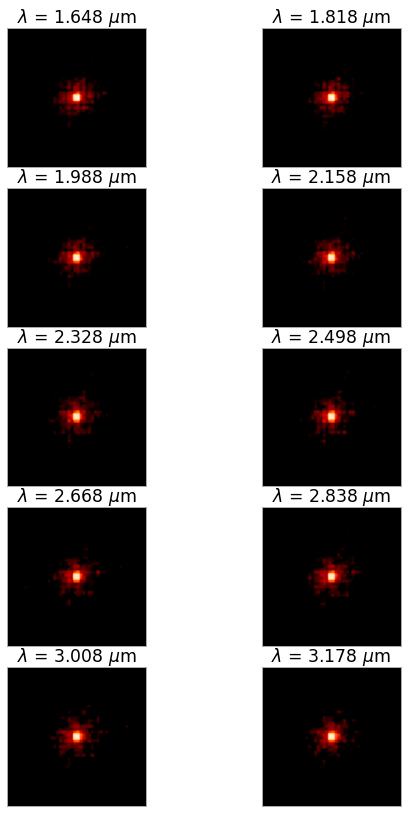

In [32]:
#Display the contents of the data cube
fig9, ax9 = plt.subplots(nrows=5, ncols=2, figsize=(8,12))
plt.subplots_adjust(hspace=0.15, wspace=0.01, left=0.06, 
                   right=0.94, bottom=0.05, top=0.95)
for row in range(5):
    for col in range(2):
        ax = ax9[row, col]
        w = row * 2 + col
        wl = psf_wavelengths[w]
        
        display_psf(cube_hdul, ax=ax, cube_slice=w,
                    title="$\lambda$ = {:.3f} $\mu$m".format(wl*1e6),
                    vmax=.2, vmin=1e-4, ext=1, colorbar=False)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

plt.show()

### Interpolation Methods

The method of interpolation we choose depends strongly on how the PSF varies with wavelength. For evaluating the different methods, we'll create another monochromatic PSF for comparison.

In [33]:
reference_psf_hdul = instrument.calc_psf(monochromatic=3.0e-6)
reference_psf = reference_psf_hdul[1].data
ref_norm = simple_norm(reference_psf, stretch='log', min_cut=1e-4, max_cut=0.2)

The simplest way is a 3D linear interpolation, so let's see how it does.

Reference: min 7.347e-08, max 1.474e-01
Linear: min 8.734e-08, max 1.472e-01
Diff: min -1.889e-04, max 5.011e-04
Total error: 7.94203e-04


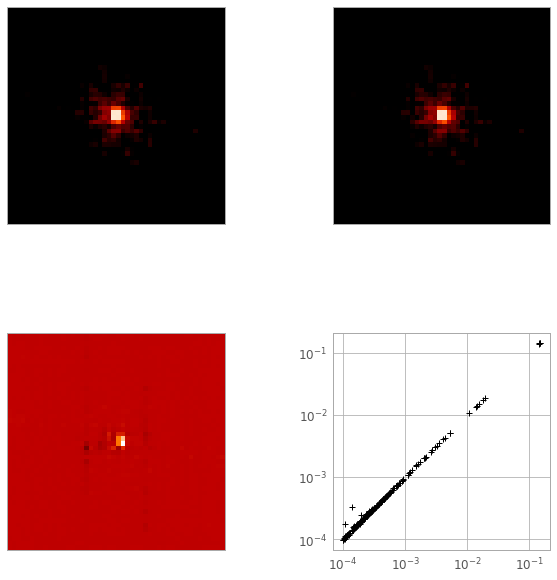

In [34]:
ref_pix = reference_psf >= 1e-4
psf_x = psf_y = np.arange(48)
out_x, out_y = np.meshgrid(psf_x, psf_y, indexing='ij')
interpolator = RegularGridInterpolator((psf_wavelengths, psf_x, psf_y), psf_cube, method='linear')
linear_psf = interpolator((3.0e-6, out_x, out_y))

diff_lin_psf = reference_psf - linear_psf

print("Reference: min {:.3e}, max {:.3e}".format(reference_psf.min(), reference_psf.max()))
print("Linear: min {:.3e}, max {:.3e}".format(linear_psf.min(), linear_psf.max()))
print("Diff: min {:.3e}, max {:.3e}".format(diff_lin_psf.min(), diff_lin_psf.max()))
print("Total error: {:.5e}".format(np.sqrt((diff_lin_psf**2).sum())))

figA, axA = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
plt.subplots_adjust(wspace=0.01, left=0.05, right=0.95)
axA[0, 0].imshow(reference_psf, interpolation='none', norm=ref_norm)
axA[0, 0].xaxis.set_visible(False)
axA[0, 0].yaxis.set_visible(False)
axA[0, 1].imshow(linear_psf, interpolation='none', norm=ref_norm)
axA[0, 1].xaxis.set_visible(False)
axA[0, 1].yaxis.set_visible(False)
axA[1, 0].imshow(diff_lin_psf, interpolation='none', vmin=-5e-4, vmax=5e-4)
axA[1, 0].xaxis.set_visible(False)
axA[1, 0].yaxis.set_visible(False)
axA[1, 1].loglog(reference_psf[ref_pix], linear_psf[ref_pix], 'k+')
axA[1, 1].set_aspect('equal', 'box')
plt.show()

The next method is more calculation-intensive, but could be more accurate. We go pixel-by-pixel through the PSF cube and interpolate with a 1D cubic spline along the wavelength axis.

Reference: min 7.347e-08, max 1.474e-01
Cubic: min 8.267e-08, max 1.472e-01
Diff: min -1.865e-04, max 5.021e-04
Total error: 8.06170e-04


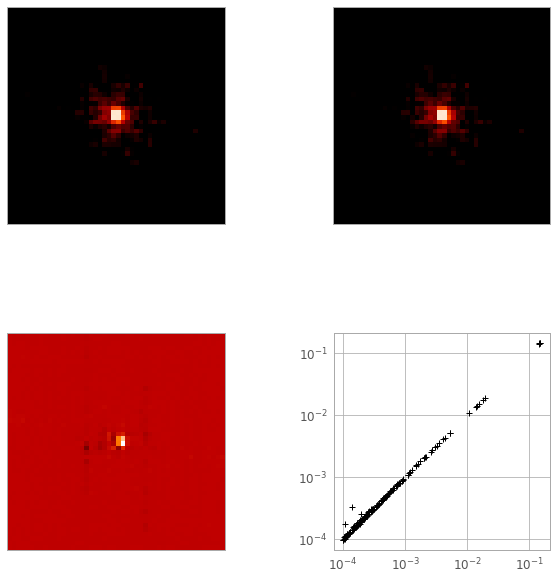

In [35]:
cubic_psf = np.zeros_like(psf_cube[0])
for row in np.arange(48):
    for col in np.arange(48):
        spline = interp1d(psf_wavelengths, psf_cube[:, row, col], kind='cubic')
        cubic_psf[row, col] = spline(3.0e-6)
        
diff_cub_psf = reference_psf - cubic_psf

print("Reference: min {:.3e}, max {:.3e}".format(reference_psf.min(), reference_psf.max()))
print("Cubic: min {:.3e}, max {:.3e}".format(cubic_psf.min(), cubic_psf.max()))
print("Diff: min {:.3e}, max {:.3e}".format(diff_cub_psf.min(), diff_cub_psf.max()))
print("Total error: {:.5e}".format(np.sqrt((diff_cub_psf**2).sum())))

figB, axB = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
plt.subplots_adjust(wspace=0.01, left=0.05, right=0.95)
axB[0, 0].imshow(reference_psf, interpolation='none', norm=ref_norm)
axB[0, 0].xaxis.set_visible(False)
axB[0, 0].yaxis.set_visible(False)
axB[0, 1].imshow(cubic_psf, interpolation='none', norm=ref_norm)
axB[0, 1].xaxis.set_visible(False)
axB[0, 1].yaxis.set_visible(False)
axB[1, 0].imshow(diff_cub_psf, interpolation='none', vmin=-5e-4, vmax=5e-4)
axB[1, 0].xaxis.set_visible(False)
axB[1, 0].yaxis.set_visible(False)
axB[1, 1].loglog(reference_psf[ref_pix], cubic_psf[ref_pix], 'k+')
axB[1, 1].set_aspect('equal', 'box')
plt.show()

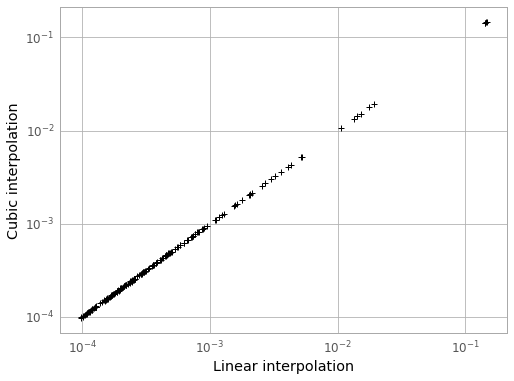

In [36]:
figC = plt.figure()
plt.loglog(linear_psf[ref_pix], cubic_psf[ref_pix], 'k+')
plt.xlabel('Linear interpolation')
plt.ylabel('Cubic interpolation')
plt.show()

It turns out that the linear interpolation method is better! The total error is ~3 times smaller than the cubic splines.

### Full trace PSF

Now we can generate a full PSF for the spectral trace. Note that the PSF at each wavelength is going to be a linear combination of the overlapping adjacent monochromatic PSFs. If geometric distortion is present, it may be beneficial to create this PSF *after* the trace centers have been fit.

In [37]:
cube_w, cube_x, cube_y = np.meshgrid(wavelength * 1e-6, psf_x, psf_y, indexing='ij')
full_psf_cube = interpolator((cube_w, cube_x, cube_y))
nw, ny, nx = full_psf_cube.shape
half = ny // 2
trace = np.zeros((ny, nw), dtype=float)

for wl, psf in enumerate(full_psf_cube):
    lo = wl - half
    lo_w = max(lo, 0)
    lo_x = lo_w - lo
    hi = wl + half
    hi_w = min(hi, nw)
    hi_x = nx - (hi - hi_w)
    trace[:, lo_w:hi_w] += psf[:, lo_x:hi_x]

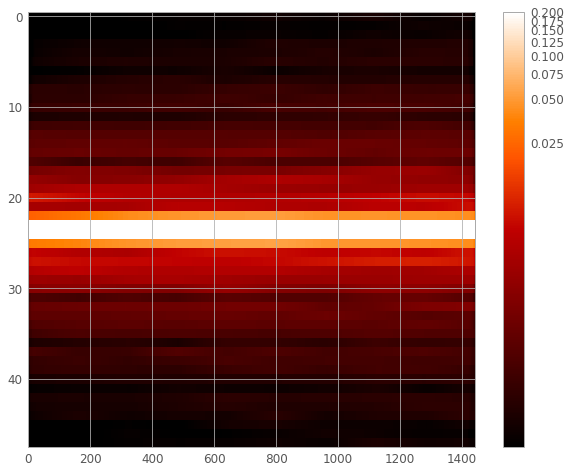

In [38]:
figD = plt.figure(figsize=(10, 8))
trace_norm = simple_norm(trace, stretch='log', min_cut=1e-4, max_cut=0.2)
plt.imshow(trace, interpolation='none', aspect='auto', norm=trace_norm)
plt.colorbar()
plt.show()

### Resampling the trace

We need a final resampling of our idealized trace to the location of the spectrum in the extraction region. To do this, we can use our old friend `RegularGridInterpolator`. We set the center of the WebbPSF trace (originally at row 23) to our fit trace center, and resample appropriately.

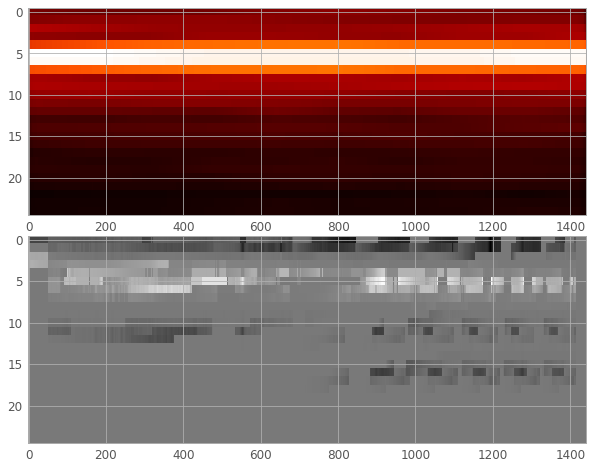

In [39]:
trace_row = np.arange(ny)
trace_interpolator = RegularGridInterpolator((trace_row, wavelength), trace)
center_0 = 23
center_1 = fit_extraction_kernel.mean_0

out_lo = center_0 - center_1
out_hi = out_lo + er_ny

resample_row = np.linspace(out_lo, out_hi, er_ny)
resample_y, resample_w = np.meshgrid(resample_row, wavelength, indexing='ij')

resampled_trace = trace_interpolator((resample_y, resample_w))

figE, axE = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.1)
trace_renorm = simple_norm(resampled_trace, stretch='log')
axE[0].imshow(resampled_trace, interpolation='none', aspect='auto', norm=trace_renorm)
axE[1].imshow(extraction_region, cmap='gray', aspect='auto', 
                  norm=er_norm, interpolation='none')
plt.show()

## About this notebook
**Author:** Graham Kanarek, Staff Scientist, Science Support  
**Updated On:** 2020-05-11

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 